In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [2]:
# Hochladen beider .csv Dateien: kunden & besucher
kunden = pd.read_csv('kunden.csv', sep = ';')
besucher = pd.read_csv('besucher.csv', sep = ';')

# Hinzufügen einer neuen Spalte mit einem Standardwert
besucher['Preis'] = 'NaN'

# Anpassen der Spaltenreihenfolge, um 'Preis'-Spalte in besucher als dritte Spalte zu setzen
cols = list(besucher.columns)
cols.insert(2, cols.pop(cols.index('Preis')))
besucher = besucher[cols]

# Zusammenfügen der DataFrames untereinander (vertikal)
combined_draft = pd.concat([kunden, besucher], ignore_index=True, axis = 0)

# Sortieren des kombinierten DataFrames nach der Spalte 'KundeNr' aufsteigend
combined_sorted = combined_draft.sort_values(by='KundeNr')

# Gruppieren der Werte nach Überschrift
combined_gruppen = combined_draft.groupby('Geschlecht').size().reset_index(name='Anzahl')

# Zählen der Fehlerwerte in allen Spalten
na_count = combined_draft.isna().sum()

# Ausgabe des sortierten DataFrames
print(combined_draft)

      Alter          Einkommen     Preis  Geschlecht  Zeit KundeNr
0        64            66894.0  88160.31         1.0  43.0   K0310
1        54            77644.0  103145.7         1.0  40.0   K1042
2        55            44341.0  80565.16         0.0  37.0   K0382
3        49            67271.0  83949.89         0.0  42.0   K0498
4        46            49832.0  93781.58         0.0  41.0   K0552
...     ...                ...       ...         ...   ...     ...
1990     32  34391,82496545645       NaN         1.0  48,0   K1211
1991     41  68516,49543941053       NaN         0.0  34,0   K1375
1992     65  89685,33344089528       NaN         0.0  23,0   K1965
1993     68  95714,30526812703       NaN         0.0  32,0   K1540
1994     49   73319,1870845747       NaN         0.0  27,0   K1207

[1995 rows x 6 columns]


In [3]:
land = pd.read_csv('geo.txt', sep = '\t')

# Ersetzen der Werte in der Spalte "Niederlassung"
land['Niederlassung'] = land['Niederlassung'].replace({
    'NRW': 'Nordrhein-Westfalen',
    'Düsseldorf': 'Nordrhein-Westfalen',
    'Berlin-Charlottenburg': 'Berlin',
    'Berlin-Mitte': 'Berlin',
    'BERLIN': 'Berlin'
})

# Gruppieren nach der Spalte "Niederlassung" und Zählen der Einträge in jeder Gruppe/ Überprüfen auf Richtigkeit der Bundesländer
land_gruppen = land.groupby('Niederlassung').size().reset_index(name='Anzahl')

land

,KundeNr,Niederlassung
0,K0001,Sachsen
1,K0002,Nordrhein-Westfalen
2,K0003,Hessen
3,K0004,Bayern
4,K0005,Bayern
...,...,...
1990,K1991,Hessen
1991,K1992,Baden-Württemberg
1992,K1993,Nordrhein-Westfalen
1993,K1994,Berlin


In [4]:
# Anpassen der Spaltenreihenfolge, um "Niederlassung" als siebente (in Python sechste, weil Beginn = 0) Spalte zu setzen
cols = list(combined_draft.columns)
cols.insert(6, cols.pop(cols.index('KundeNr')))
combined = combined_draft[cols]

# Zusammenführen von "combined_draft" und "land", Sortierung nach "KundeNr" und Einfügen der "Niederlassung" Werte in Spalte "Niederlassung"
combined = pd.merge(combined_draft, land, on='KundeNr', how='right')

# Ersetzen von Kommas durch Punkte in allen Spalten
combined['Zeit'] = combined['Zeit'].astype(str).str.replace(',', '.', regex=False)
combined['Einkommen'] = combined['Einkommen'].astype(str).str.replace(',', '.', regex=False)
combined['Preis'] = combined['Preis'].astype(str).str.replace(',', '.', regex=False)
combined['Geschlecht'] = combined['Geschlecht'].astype(str).str.replace(',', '.', regex=False)

spalten_int = ['Einkommen', 'Preis']
for col in spalten_int:
    combined[col] = pd.to_numeric(combined[col], errors='coerce')

# Runden der Werte in 'Einkommen' und 'Preis'
combined['Einkommen'] = combined['Einkommen'].round(2)
combined['Preis'] = combined['Preis'].round(2)

# Speichern des aktualisierten DataFrames in eine neue CSV-Datei
# combined_df.to_csv('final_project/kunden_mit_niederlassung.csv', index=False)

spalten = ['Alter', 'Einkommen', 'Preis', 'Zeit']

# Berechnen der Z-Scores für die oben angegebenen Spalten
numeric_cols = combined.select_dtypes(include=np.number).columns
z_scores = combined[numeric_cols].apply(zscore)

# Ersetzen der Werte mit dem Medianwert, die einen Z-Score <3 oder >3 haben
for col in numeric_cols:
    median = combined[col].median()
    combined[col] = np.where(np.abs(z_scores[col]) > 3, median, combined[col])

# Ausgabe des Ergebnisses
combined

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Niederlassung
0,68.0,89437.00,114481.90,1.0,62.0,K0001,Sachsen
1,58.0,65271.00,106258.99,1.0,44.0,K0002,Nordrhein-Westfalen
2,44.0,48195.00,85705.57,1.0,29.0,K0003,Hessen
3,37.0,48957.00,76412.36,0.0,36.0,K0004,Bayern
4,50.0,56621.00,92898.67,0.0,40.0,K0005,Bayern
...,...,...,...,...,...,...,...
1990,48.0,59967.31,NaN,1.0,21.0,K1991,Hessen
1991,67.0,81521.76,NaN,1.0,21.0,K1992,Baden-Württemberg
1992,40.0,41616.57,NaN,0.0,48.0,K1993,Nordrhein-Westfalen
1993,49.0,76602.79,NaN,1.0,19.0,K1994,Berlin


In [5]:
# Speichern des aktualisierten DataFrames in eine neue CSV-Datei
combined.to_csv('combined.csv', index=False)

# F1. Wie viele Autos wurden verkauft?

In [6]:
# Importieren der zusammengefügten Datei "combined.csv" und Aufteilen der Werte in Zeilen
# combined = pd.read_csv('combined.csv', sep = ',')

# Zählen der Preis und dadurch die Anzahl der verkauften Autos
verkaufte_autos  = combined['Preis'].count()

# Ausgeben des Ergebnisses
print(f"Es wurden insgesamt {verkaufte_autos} Autos verkauft.")

Es wurden insgesamt 1104 Autos verkauft.


# F2. Was ist der Höchst-, Mindest- und Durchschnittspreis der verkauften Autos?


In [7]:
max_preis = combined['Preis'].astype(float).max()
min_preis = combined['Preis'].astype(float).min()
avg_preis = combined['Preis'].astype(float).mean()

print(f"F2: Höchstpreis: {max_preis}, Mindestpreis: {min_preis}, Durchschnittspreis: {avg_preis: .2f}")

F2: Höchstpreis: 165482.31, Mindestpreis: 21471.65, Durchschnittspreis:  88975.20


# F3.Wie hoch war der Gesamtumsatz?

In [8]:
# Berechnung des Gesamtumsatzes (Summe der Preise) 
gesamtumsatz = combined['Preis'].astype(float).sum() 
print(f"Gesamtumsatz: {gesamtumsatz}")


Gesamtumsatz: 98228619.38


# F4. Wie viele Autos wurden pro Bundesland verkauft?

In [9]:
# combined = pd.read_csv('combined.csv')

# Gruppieren der Bundesländer und Zählen der Preise, daher auch Anzahl verkaufter Autos. Zurücksetzen des Indexes.
verkäufe_pro_bundesland = combined.groupby('Niederlassung')['Preis'].count().reset_index()

# Umbenennen der Spalten "Niederlassung" und "Preis"
verkäufe_pro_bundesland = verkäufe_pro_bundesland.rename(columns={'Niederlassung': 'Bundesland', 'Preis': 'Verkaufte Autos'}).sort_values('Verkaufte Autos').reset_index(drop = True)

# Überschrift für das Ergebnis
print("Anzahl verkaufter Autos pro Bundesland:\n")

# Ausgeben des Ergebnisses und Entfernen des Indexes
print(verkäufe_pro_bundesland.to_string(index = False))

Anzahl verkaufter Autos pro Bundesland:

         Bundesland  Verkaufte Autos
        Brandenburg               37
            Hamburg               43
          Thüringen               49
            Sachsen               89
             Hessen               96
      Niedersachsen               96
             Berlin              126
Nordrhein-Westfalen              175
             Bayern              188
  Baden-Württemberg              205


# F5. Wie hoch war der durchschnittliche Umsatz pro Bundesland?

In [10]:
bundeslaender= combined[combined['Preis'].notna()]['Niederlassung'].unique()

umsatz_pro_bundesland = {}

for bundesland in bundeslaender:
    umsatz_pro_bundesland[bundesland] = combined[(combined['Niederlassung'] == bundesland) & (combined['Preis'].notna())]['Preis'].astype(float).mean()
    
umsatz_pro_bundesland_df = pd.DataFrame(umsatz_pro_bundesland.items(), columns=['Niederlassung','Durchschnittlicher Umsatz'])

umsatz_pro_bundesland_df['Durchschnittlicher Umsatz'] = umsatz_pro_bundesland_df['Durchschnittlicher Umsatz'].round(2)
umsatz_pro_bundesland_df = umsatz_pro_bundesland_df.sort_values(by='Durchschnittlicher Umsatz', ascending=False)


print(f"F5: Durchschnittlicher Umsatz pro Bundesland:\n{umsatz_pro_bundesland_df.to_string(index=False)}")


F5: Durchschnittlicher Umsatz pro Bundesland:
      Niederlassung  Durchschnittlicher Umsatz
  Baden-Württemberg                   90969.56
          Thüringen                   90816.99
             Berlin                   89584.98
            Sachsen                   89455.08
             Bayern                   89344.31
Nordrhein-Westfalen                   88633.27
      Niedersachsen                   87963.31
        Brandenburg                   86673.64
             Hessen                   85864.93
            Hamburg                   85549.50


# F6. In welchem Bundesland wurde das teuerste Auto verkauft?

In [11]:
# Zuerst sicherstellen, dass die Preise als Float interpretiert werden können
combined['Preis'] = combined['Preis'].astype(float)

# Bundesländer mit dem höchsten durchschnittlichen Preis ermitteln
durchschnittlicher_preis_pro_bundesland = combined.groupby('Niederlassung')['Preis'].mean()
teuerstes_bundesland = durchschnittlicher_preis_pro_bundesland.idxmax()
hoechster_preis = durchschnittlicher_preis_pro_bundesland.max()

print(f"Das teuerste Auto wurde im Bundesland {teuerstes_bundesland} verkauft, mit einem Durchschnittspreis von {hoechster_preis:.2f}.")



Das teuerste Auto wurde im Bundesland Baden-Württemberg verkauft, mit einem Durchschnittspreis von 90969.56.


# F7. Haben mehr Frauen oder mehr Männer unsere Autos gekauft?

In [12]:
# combined = pd.read_csv('combined.csv')

# Filtern nach "Preis", sodass nur die verkauften Autos betrachtet werden
verkaufte_autos = combined.dropna(subset=['Preis'])

# Anzahl der verkauften Autos nach Geschlecht zählen
geschlechter = verkaufte_autos['Geschlecht'].value_counts()

# Berechnung der Ergebnisse
maenner = geschlechter.get(1, 0)
frauen = geschlechter.get(0, 0)

# Ausgabe der Ergbenisse
print(f"Insgesamt haben {maenner} Männer unsere Autos gekauft.")
print(f"Insgesamt haben {frauen} Frauen unsere Autos gekauft.\n")

# Berechnung und Ausgabe des Ergebnisses, ob mehr männliche oder mehr weibliche Kunden
if maenner > frauen:
    print("Wir haben mehr männliche Kunden.")
elif frauen > maenner:
    print("Wir haben mehr weibliche Kunden.")
else:
    print("Unsere Kundschaft ist zu gleichen Teilen männlich und weiblich.")

Insgesamt haben 398 Männer unsere Autos gekauft.
Insgesamt haben 701 Frauen unsere Autos gekauft.

Wir haben mehr weibliche Kunden.


# F8. Wie hoch ist das Durchschnittsalter unserer Kunden? Wie hoch ist das Durchschnittsalter unserer Besucher?


In [13]:
# Lesen der bereinigten und zusammengeführten Daten
combined = pd.read_csv('H:/Documents/final_projectSS24_Group5/combined.csv')

# Sicherstellen, dass die Daten korrekt eingelesen wurden
print(combined.head())


   Alter  Einkommen      Preis  Geschlecht  Zeit KundeNr        Niederlassung
0   68.0    89437.0  114481.90         1.0  62.0   K0001              Sachsen
1   58.0    65271.0  106258.99         1.0  44.0   K0002  Nordrhein-Westfalen
2   44.0    48195.0   85705.57         1.0  29.0   K0003               Hessen
3   37.0    48957.0   76412.36         0.0  36.0   K0004               Bayern
4   50.0    56621.0   92898.67         0.0  40.0   K0005               Bayern


In [14]:
#Funktion zur Entfernung von Ausreißern IQR:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column]>= lower_bound)&(df[column]<= upper_bound)]

In [15]:
#Aufteilung Kunden/Besucher
kunden = combined[combined['Preis'].notna()]
besucher = combined[combined['Preis'].isna()]

#Aureißer werden entfernt
kunden = remove_outliers(kunden, 'Alter')
besucher = remove_outliers(besucher, 'Alter')

#Durchschnittsalter der beiden Gruppen
avg_alter_kunden = kunden['Alter'].astype(float).mean()
avg_alter_besucher = besucher['Alter'].astype(float).mean()

#Print
print(f"F8: Durchschnittliches Alter der Kunden: {avg_alter_kunden}")
print(f"F8: Durchschnittliches Alter der Besucher: {avg_alter_besucher}")


F8: Durchschnittliches Alter der Kunden: 50.375
F8: Durchschnittliches Alter der Besucher: 49.88103254769921


# F9. Wie hoch ist das Durchschnittseinkommen unserer Kunden? Wie hoch ist das Durchschnittseinkommen unserer Besucher?

# +

# F10. Bestimmen Sie, ob es einen statistisch signifikanten Unterschied zwischen dem Durchschnittseinkommen der Kunden und dem Durchschnittseinkommen der Besucher gibt.

In [16]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)   #AUF AUFREIßER AUFPASSEN!!!!
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Bereinigung der Daten
kunden_einkommen = combined[combined['Preis'].notna()]['Einkommen']
besucher_einkommen = combined[combined['Preis'].isna()]['Einkommen']

# Entfernen der Ausreißer
kunden_einkommen_cleaned = remove_outliers(combined[combined['Preis'].notna()], 'Einkommen')['Einkommen']
besucher_einkommen_cleaned = remove_outliers(combined[combined['Preis'].isna()], 'Einkommen')['Einkommen']

# Durchschnittseinkommen after Cleanup - Frage 9
avg_einkommen_kunden_cleaned = kunden_einkommen_cleaned.mean()
avg_einkommen_besucher_cleaned = besucher_einkommen_cleaned.mean()

print(f"Durchschnittseinkommen der Kunden : {avg_einkommen_kunden_cleaned:.2f} Euro")
print(f"Durchschnittseinkommen der Besucher : {avg_einkommen_besucher_cleaned:.2f} Euro")

# Zweistichproben-t-Test mit bereinigten Daten
t_stat, p_val = ttest_ind(
    kunden_einkommen_cleaned,
    besucher_einkommen_cleaned,
    equal_var=True
)

# Signifikanzniveau
alpha = 0.05

# Überprüfung, ob der Unterschied statistisch signifikant ist
signifikanz = 'statistisch signifikant' if p_val < alpha else 'nicht statistisch signifikant'
print(f"Der Unterschied im Durchschnittseinkommen zwischen Kunden und Besuchern ist {signifikanz} (p-Wert: {p_val:.4f}).")

Durchschnittseinkommen der Kunden : 58850.55 Euro
Durchschnittseinkommen der Besucher : 59420.53 Euro
Der Unterschied im Durchschnittseinkommen zwischen Kunden und Besuchern ist nicht statistisch signifikant (p-Wert: 0.4365).


# F11. Wie hoch ist die Korrelation (Pearson-Korrelation) zwischen den Variablen Alter, Einkommen, Preis und Zeit?

In [17]:
# Um die Korrelation zu berechnen, verwenden wir die corr()-Funktion von Pandas DataFrame
correlation_matrix = combined[['Alter', 'Einkommen', 'Preis', 'Zeit']].astype(float).corr(method='pearson')

# Ausgabe der Korrelationsmatrix
print("Pearson-Korrelation zwischen Alter, Einkommen, Preis und Zeit:")
print(correlation_matrix)


Pearson-Korrelation zwischen Alter, Einkommen, Preis und Zeit:
              Alter  Einkommen     Preis      Zeit
Alter      1.000000   0.769915  0.780478  0.315136
Einkommen  0.769915   1.000000  0.864833  0.388928
Preis      0.780478   0.864833  1.000000  0.707778
Zeit       0.315136   0.388928  0.707778  1.000000


# F12. Testen Sie grafisch mit Hilfe eines qq-Plots, ob die Variable Zeit approximativ normalverteilt ist.

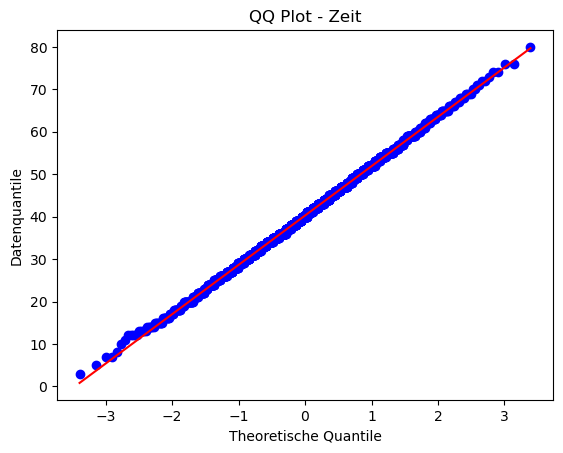

In [18]:
# Umwandeln der Zeit-Spalte in float und Behandlung von NaN-Werten
combined['Zeit'] = pd.to_numeric(combined['Zeit'], errors='coerce')

# Entfernen von NaN-Werten, da sie den QQ-Plot beeinflussen können
zeit_clean = combined['Zeit'].dropna()

# Erstellen des QQ-Plots
stats.probplot(zeit_clean, dist="norm", plot=plt)
plt.title('QQ Plot - Zeit')
plt.xlabel('Theoretische Quantile')
plt.ylabel('Datenquantile')
plt.show()


# F13. Wie viele Kunden haben keinen Bankkredit aufgenommen, um das Auto zu kaufen?

In [19]:
# combined = pd.read_csv('combined.csv')

# Annahme: Kunden, deren Gehalt höher ist als der Kaufpreis nehmen keinen Kredit auf
kunden_mit_kredit = combined[combined['Einkommen'] < combined['Preis']]

# Kunden die einen Kredit aufgenommen haben zählen
kredite = len(kunden_mit_kredit)

# Ausgabe des Ergebnisses
print(f"Es haben insgesamt {kredite} Kunden einen Kredit für den Kauf aufgenommen.")

Es haben insgesamt 1099 Kunden einen Kredit für den Kauf aufgenommen.


# F14. Welche sozioökonomischen Merkmale beeinflussen den Kaufpreis? Wählen Sie die geeigneten unabhängigen Variablen aus und schätzen Sie eine Regression unter Verwendung der geeigneten Methode.

In [20]:
# Daten einlesen
combined = pd.read_csv('combined.csv')

# Sicherstellen, dass die relevanten Spalten vorhanden sind
print(combined.columns)

# Umwandeln von relevanten Spalten in numerische Werte
combined['Alter'] = pd.to_numeric(combined['Alter'], errors='coerce')
combined['Einkommen'] = pd.to_numeric(combined['Einkommen'], errors='coerce')
combined['Preis'] = pd.to_numeric(combined['Preis'], errors='coerce')
combined['Zeit'] = pd.to_numeric(combined['Zeit'], errors='coerce')

# Filtern der Daten um NaN-Werte zu entfernen (aber keine Ausreißer filtern)
combined = combined.dropna(subset=['Preis', 'Alter', 'Einkommen', 'Zeit'])

# Unabhängige Variablen
X = combined[['Alter', 'Einkommen', 'Zeit']]

# Abhängige Variable
y = combined['Preis']

# Hinzufügen eines konstanten Terms zur Regressionsgleichung
X = sm.add_constant(X)

# Regression durchführen
model = sm.OLS(y, X).fit()

# Zusammenfassung des Modells ausgeben
print(model.summary())

Index(['Alter', 'Einkommen', 'Preis', 'Geschlecht', 'Zeit', 'KundeNr',
       'Niederlassung'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                  Preis   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     1475.
Date:                Thu, 27 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:53:17   Log-Likelihood:                -11831.
No. Observations:                1104   AIC:                         2.367e+04
Df Residuals:                    1100   BIC:                         2.369e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

# F15. Prognostizieren Sie den Kaufpreis eines unserer Autos für einen männlichen kunden im Alter von 32 Jahren mit einem Einkommen von 30.000 Euro. Prognostizieren Sie den Kaufpreis eines unserer Autos für einen männlichen Kunden im Alter von 51 Jahren und mit einem Einkommen von 54.000 Euro.

In [21]:
# Zusammenfügen der DataFrames
besucher['Preis'] = np.nan
cols = list(besucher.columns)
cols.insert(2, cols.pop(cols.index('Preis')))
besucher = besucher[cols]
combined_draft = pd.concat([kunden, besucher], ignore_index=True, axis=0)

# Ersetzen von Kommas durch Punkte und Konvertieren der Spalten in numerische Werte
combined_draft['Einkommen'] = combined_draft['Einkommen'].astype(str).str.replace(',', '.').astype(float)
combined_draft['Preis'] = combined_draft['Preis'].astype(str).str.replace(',', '.').astype(float)
combined_draft['Alter'] = combined_draft['Alter'].astype(int)
combined_draft['Geschlecht'] = combined_draft['Geschlecht'].astype(float)

# Filtern der Daten für männliche Kunden
males = combined_draft[combined_draft['Geschlecht'] == 1.0]

# Entfernen von Zeilen mit fehlenden Werten
males = males.dropna(subset=['Preis'])

# Lineare Regression
X = males[['Alter', 'Einkommen']]
y = males['Preis']
# Modelltraining
model = LinearRegression()
model.fit(X, y)

# Prognose für die beiden gegebenen Fälle
kunden1 = np.array([[32, 30000]])
kunden2 = np.array([[51, 54000]])

preis1 = model.predict(kunden1)
preis2 = model.predict(kunden2)

print(f'Prognostizierter Kaufpreis für einen 32-jährigen Kunden mit einem Einkommen von 30.000 Euro: {preis1[0]:.2f} Euro')
print(f'Prognostizierter Kaufpreis für einen 51-jährigen Kunden mit einem Einkommen von 54.000 Euro: {preis2[0]:.2f} Euro')


Prognostizierter Kaufpreis für einen 32-jährigen Kunden mit einem Einkommen von 30.000 Euro: 51393.47 Euro
Prognostizierter Kaufpreis für einen 51-jährigen Kunden mit einem Einkommen von 54.000 Euro: 85540.93 Euro


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


# F16. Welche Variable beeinflusst den Preis des Autos am meisten?

In [22]:
# combined = pd.read_csv('combined.csv')

# Entfernen von Zeilen mit fehlenden Werten in den relevanten Spalten
combined = combined.dropna()

# Entfernen von negativen Werten in den Spalten "Einkommen" und "Preis"
combined = combined[(combined['Einkommen'] >= 0) & (combined['Preis'] >= 0)]

# Konvertieren von Kategorien in numerische Werte (falls notwendig)
if 'Geschlecht' in combined.columns:
    combined = pd.get_dummies(combined, columns=['Geschlecht'], drop_first=True)
else:
    print("Warnung: Die Spalte 'Geschlecht' ist nicht im DataFrame enthalten.")

# Auswahl der Merkmale und der Zielvariable
features = ['Alter', 'Einkommen'] + [col for col in combined.columns if 'Geschlecht' in col]
target = 'Preis'
X = combined[features]
y = combined[target]

# Standardisieren der Merkmale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Durchführen der Regressionsanalyse
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
#print(f'Modell R^2 Score: {score}')

# Regressionskoeffizienten anzeigen
coefficients = model.coef_
coeff_df = pd.DataFrame(coefficients, index=features, columns=['Koeffizient'])
print(coeff_df.round(2))

# Interpretieren der Regressionskoeffizienten
max_coefficient = coeff_df.max().round(2)[0]
print()
print(f"Die Variable 'Einkommen' hat mit einem Wert von {max_coefficient} den höchsten absoluten Koeffizientenwert und beeinflusst damit den Preis des Autos am meisten.")

                Koeffizient
Alter               7095.29
Einkommen          16267.47
Geschlecht_1.0      1235.64

Die Variable 'Einkommen' hat mit einem Wert von 16267.47 den höchsten absoluten Koeffizientenwert und beeinflusst damit den Preis des Autos am meisten.


# F17. Schätzen Sie eine Regression, die die Wahrscheinlichkeit des Kaufs eines Autos ermittelt. 

In [23]:
combined = pd.read_csv('combined.csv')

print(combined.columns)

# Umwandeln  in numerische Werte
combined['Alter'] = pd.to_numeric(combined['Alter'], errors='coerce')
combined['Einkommen'] = pd.to_numeric(combined['Einkommen'], errors='coerce')
combined['Preis'] = pd.to_numeric(combined['Preis'], errors='coerce')
combined['Zeit'] = pd.to_numeric(combined['Zeit'], errors='coerce')

#  binäre Zielvariable 'Gekauft'
combined['Gekauft'] = np.where(combined['Preis'].notna(), 1, 0)

# Filtern der Daten (NaN entfernen)
combined = combined.dropna(subset=['Alter', 'Einkommen', 'Zeit'])

# Unabhängige Variablen
X = combined[['Alter', 'Einkommen', 'Zeit']]

# Abhängige Variable
y = combined['Gekauft']

# Intercept
X = sm.add_constant(X)

# Logistische Regression
logit_model = sm.Logit(y, X).fit()

# Print des Modells
print(logit_model.summary())

# Wahrscheinlichkeitenberechnen
combined['Kaufwahrscheinlichkeit'] = logit_model.predict(X)

# Anzeige der Wahrscheinlichkeiten für die ersten Zeilen
print(combined[['Alter', 'Einkommen', 'Zeit', 'Kaufwahrscheinlichkeit']].head())



Index(['Alter', 'Einkommen', 'Preis', 'Geschlecht', 'Zeit', 'KundeNr',
       'Niederlassung'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.580267
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Gekauft   No. Observations:                 1995
Model:                          Logit   Df Residuals:                     1991
Method:                           MLE   Df Model:                            3
Date:                Thu, 27 Jun 2024   Pseudo R-squ.:                  0.1559
Time:                        06:53:17   Log-Likelihood:                -1157.6
converged:                       True   LL-Null:                       -1371.4
Covariance Type:            nonrobust   LLR p-value:                 2.316e-92
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

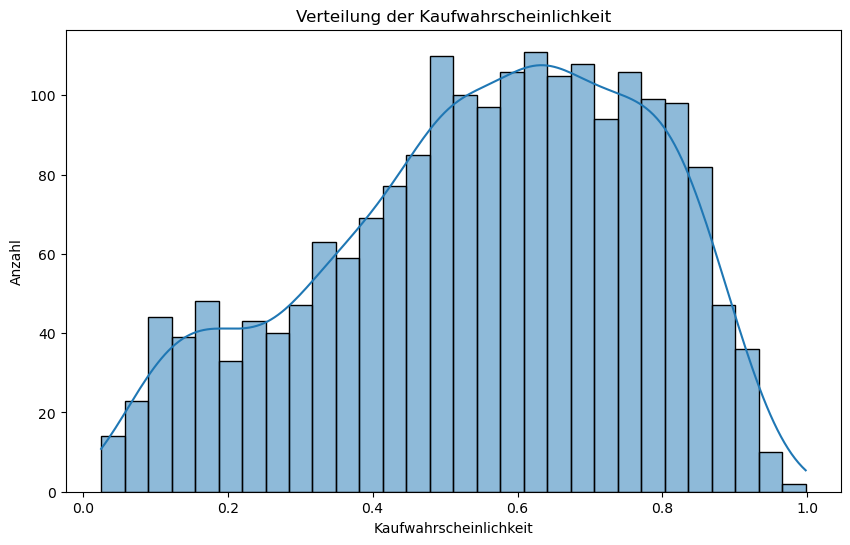

In [24]:
# Visualisierung der Kaufwahrscheinlichkeit
plt.figure(figsize=(10, 6))
sns.histplot(combined['Kaufwahrscheinlichkeit'], bins=30, kde=True)
plt.title('Verteilung der Kaufwahrscheinlichkeit')
plt.xlabel('Kaufwahrscheinlichkeit')
plt.ylabel('Anzahl')
plt.show()

# F18. Wie hoch ist die Wahrscheinlichkeit, dass ein 32-Jähriger männlicher Kunde mit einem Einkommen von 30.000 Euro, der das Auto 30 Minuten lang getestet hat, eines unserer Modelle kauft? Wie hoch ist die Wahrscheinlichkeit, dass ein 51-Jähriger männlicher Kunde mit einem Einkommen von 54.000 euro, der das Auto 45 Minuten lang getestet hat, eines unserer Modelle kauft?


In [25]:
combined = pd.read_csv('combined.csv')

print("Spaltenübersicht:", combined.columns)

# numerische Werte
combined['Alter'] = pd.to_numeric(combined['Alter'], errors='coerce')
combined['Einkommen'] = pd.to_numeric(combined['Einkommen'], errors='coerce')
combined['Preis'] = pd.to_numeric(combined['Preis'], errors='coerce')
combined['Zeit'] = pd.to_numeric(combined['Zeit'], errors='coerce')

# Binäre Zielvariable 'Gekauft' erstellen, wobei 1 = gekauft, 0 = nicht gekauft
combined['Gekauft'] = np.where(combined['Preis'].notna(), 1, 0)

# Entfernen von Zeilen mit fehlenden Werten in den relevanten Spalten
combined = combined.dropna(subset=['Alter', 'Einkommen', 'Zeit'])

# Unabhängige Variablen 
X = combined[['Alter', 'Einkommen', 'Zeit']]

# Abhängige Variable
y = combined['Gekauft']

# Intercept zur Regressionsgleichung
X = sm.add_constant(X)

# logistische Regression
logit_model = sm.Logit(y, X).fit()

# Zusammenfassung des Modells ausgeben
print(logit_model.summary())

# Spezifikationen aus der Aufgabenstellung
# Kunde 1: 32 Jahre alt, 30.000 Euro Einkommen, 30 Minuten Testzeit
kunde_1 = {'const': 1, 'Alter': 32, 'Einkommen': 30000, 'Zeit': 30}

# Kunde 2: 51 Jahre alt, 54.000 Euro Einkommen, 45 Minuten Testzeit
kunde_2 = {'const': 1, 'Alter': 51, 'Einkommen': 54000, 'Zeit': 45}

# Umwandeln in DataFrames 
kunde_1_df = pd.DataFrame([kunde_1])
kunde_2_df = pd.DataFrame([kunde_2])

# Berechnung der Logit-Werte, sog. logodds, für die beiden Kunden
logit_kunde_1 = logit_model.predict(kunde_1_df)
logit_kunde_2 = logit_model.predict(kunde_2_df)

# Umwandlung der Werte in Prozent
wahrscheinlichkeit_kunde_1 = (1 / (1 + np.exp(-logit_kunde_1))) * 100
wahrscheinlichkeit_kunde_2 = (1 / (1 + np.exp(-logit_kunde_2))) * 100

# Ausgabe der Wahrscheinlichkeiten in Prozent
print(f"Die Wahrscheinlichkeit, dass ein 32-jähriger Kunde mit einem Einkommen von 30.000 Euro und 30 Minuten Testzeit ein Auto kauft, beträgt {wahrscheinlichkeit_kunde_1.iloc[0]:.2f}%.")
print(f"Die Wahrscheinlichkeit, dass ein 51-jähriger Kunde mit einem Einkommen von 54.000 Euro und 45 Minuten Testzeit ein Auto kauft, beträgt {wahrscheinlichkeit_kunde_2.iloc[0]:.2f}%.")

Spaltenübersicht: Index(['Alter', 'Einkommen', 'Preis', 'Geschlecht', 'Zeit', 'KundeNr',
       'Niederlassung'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.580267
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Gekauft   No. Observations:                 1995
Model:                          Logit   Df Residuals:                     1991
Method:                           MLE   Df Model:                            3
Date:                Thu, 27 Jun 2024   Pseudo R-squ.:                  0.1559
Time:                        06:53:18   Log-Likelihood:                -1157.6
converged:                       True   LL-Null:                       -1371.4
Covariance Type:            nonrobust   LLR p-value:                 2.316e-92
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

# F19. Auf welche Probleme sind Sie bei der Zusammenführung des Datensatzes gestoßen?

In [26]:
print("Folgende Probleme sind aufgetreten:\n\n"
     
    "1. Einfügen einer fehlenden Spalte: besucher['Preis'] = ''\n\n"
    "2. Einfügen der Spalte und Setzen an richtige Stelle: cols.insert()\n\n"
    "3. Ersetzen der falsch bezeichneten Bundesländer: land['Niederlassung'].replace()\n\n"
    "4. Zusammenführen der .csv und -txt Dateien: combined = pd.merge(combined_draft, land, on='KundeNr', how='right')\n\n"
    "5. Ersetzen von ',' in '.': combined['Zeit'].astype(str).str.replace(',', '.', regex=False)\n\n"
    "6. Umwandeln der Werte in numerische Werte: combined[col] = pd.to_numeric()\n\n"
    "7. Ersetzen der Ausreißer durch den Medianwert: combined[col] = np.where(np.abs(z_scores[col]) > 3, median, combined[col])")

Folgende Probleme sind aufgetreten:

1. Einfügen einer fehlenden Spalte: besucher['Preis'] = ''

2. Einfügen der Spalte und Setzen an richtige Stelle: cols.insert()

3. Ersetzen der falsch bezeichneten Bundesländer: land['Niederlassung'].replace()

4. Zusammenführen der .csv und -txt Dateien: combined = pd.merge(combined_draft, land, on='KundeNr', how='right')

5. Ersetzen von ',' in '.': combined['Zeit'].astype(str).str.replace(',', '.', regex=False)

6. Umwandeln der Werte in numerische Werte: combined[col] = pd.to_numeric()

7. Ersetzen der Ausreißer durch den Medianwert: combined[col] = np.where(np.abs(z_scores[col]) > 3, median, combined[col])


# F20. Welche Vorschläge würden Sie der Kundenabteilung für die Umfrage im nächsten Jahr machen? Welche zusätzlichen Informationen sollten gesammelt werden? Formulieren Sie zwei Vorschläge.

# Vorschläge für die nächste Kundenumfrage

## Vorschlag 1: Erfassung von Kundenzufriedenheit und Nutzungsmuster

**Ziel:** Besseres Verständnis der Kundenzufriedenheit und Nutzungsmuster.

1. **Kundenzufriedenheit:**
   - Wie zufrieden sind Sie mit dem gekauften Elektroauto? (Skala von 1 bis 5)
   - Wie bewerten Sie den Kundenservice von Elektrauto AG? (Skala von 1 bis 5)
   - Würden Sie Elektrauto AG weiterempfehlen? (Ja oder Nein)
   
2. **Nutzungsmuster:**
   - Wie oft nutzen Sie Ihr Elektroauto pro Woche? (Anzahl der Tage)
   - Wie viele Kilometer fahren Sie durchschnittlich pro Woche? (Angabe in km/Woche)
   
   
## Vorschlag 2: Erfassung von Umweltbewusstsein und Ladeverhalten

**Ziel:** Besseres Verständnis von Umweltbewusstsein der Kunden sowie deren Ladeverhalten.

**Zusätzliche Informationen:**

1. **Umweltbewusstsein:**
   - Wie wichtig war der Umweltaspekt bei Ihrer Kaufentscheidung? (Skala von 1 bis 5)
   - Wie hoch schätzen Sie Ihren CO2-Fußabdruck im Vergleich zu vor dem Kauf des Elektroautos? (Reduziert/Unverändert/Erhöht)

2. **Ladeverhalten:**
   - Wo laden Sie Ihr Elektroauto hauptsächlich? (Zuhause/Öffentliche Ladestationen/Arbeitsplatz)
   - Wie oft laden Sie Ihr Elektroauto pro Woche?
   
   


<font size = "8">Elektrauto AG - Abschlussprojekt<font/>
    
<i> HWR Berlin, Sommersemester 2024</i>
    
<i> von Florin Alexe, Patrick Mueller, Liam Klimek</i>

<font size = "8">Praesentation der Umfrageergebnisse<font/>

## Einleitung

Willkommen zu unserer Praesentation der Umfrageergebnisse von Elektratuto AG.

Was sind die wichtigsten Erkenntnisse, die wir aus der Umfrage gewonnen haben?

## Schlüsselmetriken und Erkenntnisse

- **Anzahl der verkauften Autos:** 1104
- **Hoechster Preis eines verkauften Autos:** 165482.31 Euro
- **Durchschnittlicher Preis der verkauften Autos:** 88975.20 Euro
- **Gesamtumsatz:** 98228619.38 Euro
- **Durchschnittsalter der Kunden:** 50.37 Jahre
- **Durchschnittseinkommen der Kunden:** 58850.32 Euro

## Verkaufszahlen nach Bundesland

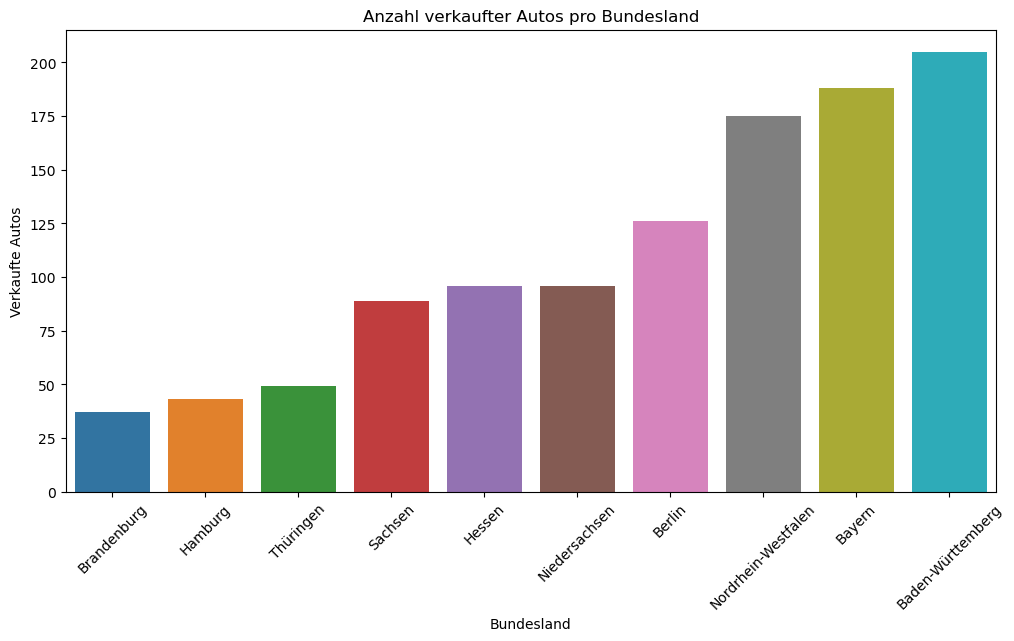

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot für Anzahl verkaufter Autos pro Bundesland
plt.figure(figsize=(12, 6))
sns.barplot(x='Bundesland', y='Verkaufte Autos', data=verkäufe_pro_bundesland)
plt.title('Anzahl verkaufter Autos pro Bundesland')
plt.xlabel('Bundesland')
plt.ylabel('Verkaufte Autos')
plt.xticks(rotation=45)
plt.show()


# Durchschnitlliche Preise nach Bundesland

Die durchschnittlichen Verkaufspreise variieren je nach Bundesland

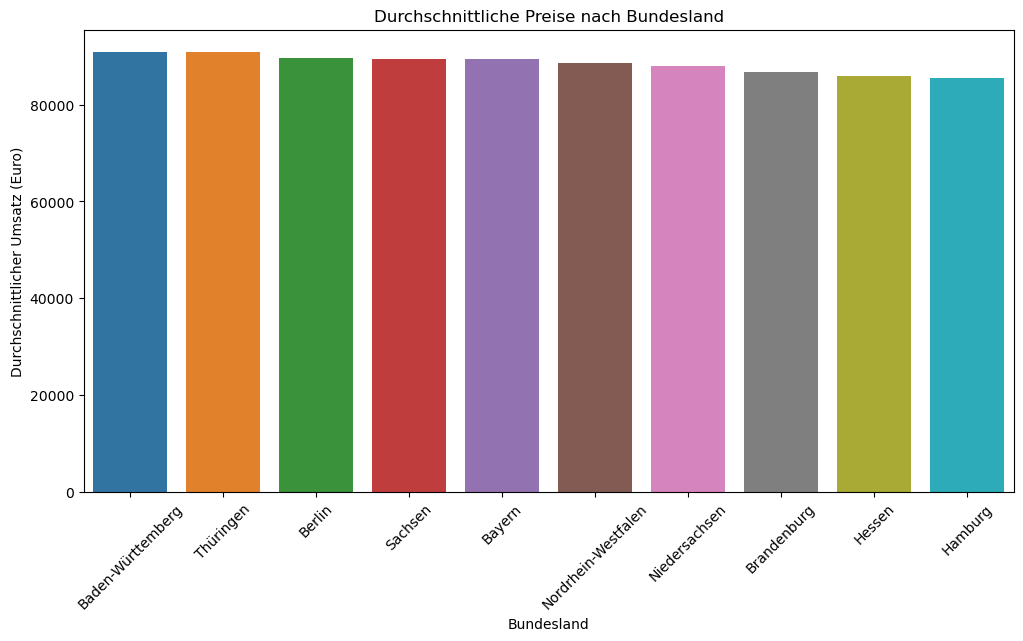

In [48]:
# Plot für Durchschnittlicher Umsatz pro Bundesland
plt.figure(figsize=(12, 6))
sns.barplot(x='Niederlassung', y='Durchschnittlicher Umsatz', data=umsatz_pro_bundesland_df)
plt.title('Durchschnittliche Preise nach Bundesland')
plt.xlabel('Bundesland')
plt.ylabel('Durchschnittlicher Umsatz (Euro)')
plt.xticks(rotation=45)
plt.show()

Baden-Wuerttemberg hat den hoechsten Durchschnittspreis fuer verkaufte Autos!

# Was wuerden wir im naechsten Jahr bei der Umfrage aendern?

# Vorschlaege fuer die naechste Kundenumfrage




## Vorschlag 1: Erfassung von Kundenzufriedenheit und Nutzungsmuster

**Ziel:** Besseres Verstaendnis der Kundenzufriedenheit und Nutzungsmuster.

1. **Kundenzufriedenheit:**
   - Wie zufrieden sind Sie mit dem gekauften Elektroauto? (Skala von 1 bis 5)
   - Wie bewerten Sie den Kundenservice von Elektrauto AG? (Skala von 1 bis 5)
   - Wuerden Sie Elektrauto AG weiterempfehlen? (Ja oder Nein)
   
2. **Nutzungsmuster:**
   - Wie oft nutzen Sie Ihr Elektroauto pro Woche? (Anzahl der Tage)
   - Wie viele Kilometer fahren Sie durchschnittlich pro Woche? (Angabe in km/Woche)

## Vorschlag 2: Erfassung von Umweltbewusstsein und Ladeverhalten

**Ziel:** Besseres Verstaendnis von Umweltbewusstsein der Kunden sowie deren Ladeverhalten.

**Zusaetzliche Informationen:**

1. **Umweltbewusstsein:**
   - Wie wichtig war der Umweltaspekt bei Ihrer Kaufentscheidung? (Skala von 1 bis 5)
   - Wie hoch schaetzen Sie Ihren CO2-Fussabdruck im Vergleich zu vor dem Kauf des Elektroautos? (Reduziert/Unveraendert/Erhoeht)

2. **Ladeverhalten:**
   - Wo laden Sie Ihr Elektroauto hauptsaechlich? (Zuhause/Oeffentliche Ladestationen/Arbeitsplatz)
   - Wie oft laden Sie Ihr Elektroauto pro Woche?

# Detaillierte Analyse (für Kollegen und Vorgesetzte)

# Datenaufbereitung und Bereinigung

# Zusammenführung der Datensätze

```python
# Hochladen beider .csv Dateien: kunden & besucher
kunden = pd.read_csv('kunden.csv', sep = ';')
besucher = pd.read_csv('besucher.csv', sep = ';')

# Hinzufuegen einer neuen Spalte mit einem Standardwert
besucher['Preis'] = 'NaN'

# Anpassen der Spaltenreihenfolge, um 'Preis'-Spalte in besucher als dritte Spalte zu setzen
cols = list(besucher.columns)
cols.insert(2, cols.pop(cols.index('Preis')))
besucher = besucher[cols]

```

```python
# Zusammenfuegen der DataFrames untereinander (vertikal)
combined_draft = pd.concat([kunden, besucher], ignore_index=True, axis = 0)

# Sortieren des kombinierten DataFrames nach der Spalte 'KundeNr' aufsteigend
combined_sorted = combined_draft.sort_values(by='KundeNr')

# Gruppieren der Werte nach Ueberschrift
combined_gruppen = combined_draft.groupby('Geschlecht').size().reset_index(name='Anzahl')

# Zaehlen der Fehlerwerte in allen Spalten
na_count = combined_draft.isna().sum()

```

# Ausgabe des sortierten DataFrames

In [29]:
print(combined_draft.head())

   Alter  Einkommen      Preis  Geschlecht  Zeit KundeNr        Niederlassung
0     68    89437.0  114481.90         1.0  62.0   K0001              Sachsen
1     58    65271.0  106258.99         1.0  44.0   K0002  Nordrhein-Westfalen
2     44    48195.0   85705.57         1.0  29.0   K0003               Hessen
3     37    48957.0   76412.36         0.0  36.0   K0004               Bayern
4     50    56621.0   92898.67         0.0  40.0   K0005               Bayern


# Niederlassung

```python
land = pd.read_csv('geo.txt', sep = '\t')

# Ersetzen der Werte in der Spalte "Niederlassung"
land['Niederlassung'] = land['Niederlassung'].replace({
    'NRW': 'Nordrhein-Westfalen',
    'Duesseldorf': 'Nordrhein-Westfalen',
    'Berlin-Charlottenburg': 'Berlin',
    'Berlin-Mitte': 'Berlin',
    'BERLIN': 'Berlin'
})

# Gruppieren nach der Spalte "Niederlassung" und Zaehlen der Eintraege in jeder Gruppe/ Überpruefen auf Richtigkeit der Bundeslaender
land_gruppen = land.groupby('Niederlassung').size().reset_index(name='Anzahl')
```

# Ausgabe des sortierten DataFrames

In [49]:
land

,KundeNr,Niederlassung
0,K0001,Sachsen
1,K0002,Nordrhein-Westfalen
2,K0003,Hessen
3,K0004,Bayern
4,K0005,Bayern
...,...,...
1990,K1991,Hessen
1991,K1992,Baden-Württemberg
1992,K1993,Nordrhein-Westfalen
1993,K1994,Berlin


# Alles zusammengefügt

```python
# Anpassen der Spaltenreihenfolge, um "Niederlassung" als siebente (in Python sechste, weil Beginn = 0) Spalte zu setzen
cols = list(combined_draft.columns)
cols.insert(6, cols.pop(cols.index('KundeNr')))
combined = combined_draft[cols]

# Zusammenfuehren von "combined_draft" und "land", Sortierung nach "KundeNr" und Einfügen der "Niederlassung" Werte in Spalte "Niederlassung"
combined = pd.merge(combined_draft, land, on='KundeNr', how='right')

# Ersetzen von Kommas durch Punkte in allen Spalten
combined['Zeit'] = combined['Zeit'].astype(str).str.replace(',', '.', regex=False)
combined['Einkommen'] = combined['Einkommen'].astype(str).str.replace(',', '.', regex=False)
combined['Preis'] = combined['Preis'].astype(str).str.replace(',', '.', regex=False)
combined['Geschlecht'] = combined['Geschlecht'].astype(str).str.replace(',', '.', regex=False)

spalten_int = ['Einkommen', 'Preis']
for col in spalten_int:
    combined[col] = pd.to_numeric(combined[col], errors='coerce')

# Runden der Werte in 'Einkommen' und 'Preis'
combined['Einkommen'] = combined['Einkommen'].round(2)
combined['Preis'] = combined['Preis'].round(2)


```

```python
# Speichern des aktualisierten DataFrames in eine neue CSV-Datei
# combined_df.to_csv('final_project/kunden_mit_niederlassung.csv', index=False)

spalten = ['Alter', 'Einkommen', 'Preis', 'Zeit']

# Berechnen der Z-Scores fuer die oben angegebenen Spalten
numeric_cols = combined.select_dtypes(include=np.number).columns
z_scores = combined[numeric_cols].apply(zscore)

# Ersetzen der Werte mit dem Medianwert, die einen Z-Score <3 oder >3 haben
for col in numeric_cols:
    median = combined[col].median()
    combined[col] = np.where(np.abs(z_scores[col]) > 3, median, combined[col])
```

# Ausgabe des Ergebnisses

In [31]:
combined

,Alter,Einkommen,Preis,Geschlecht,Zeit,KundeNr,Niederlassung,Gekauft
0,68.0,89437.00,114481.90,1.0,62.0,K0001,Sachsen,1
1,58.0,65271.00,106258.99,1.0,44.0,K0002,Nordrhein-Westfalen,1
2,44.0,48195.00,85705.57,1.0,29.0,K0003,Hessen,1
3,37.0,48957.00,76412.36,0.0,36.0,K0004,Bayern,1
4,50.0,56621.00,92898.67,0.0,40.0,K0005,Bayern,1
...,...,...,...,...,...,...,...,...
1990,48.0,59967.31,NaN,1.0,21.0,K1991,Hessen,0
1991,67.0,81521.76,NaN,1.0,21.0,K1992,Baden-Württemberg,0
1992,40.0,41616.57,NaN,0.0,48.0,K1993,Nordrhein-Westfalen,0
1993,49.0,76602.79,NaN,1.0,19.0,K1994,Berlin,0


# Beantwortung der spezifischen Fragen

# F1. Anzahl der verkauften Autos

```python
# Importieren der zusammengefuegten Datei "combined.csv" und Aufteilen der Werte in Zeilen
# combined = pd.read_csv('combined.csv', sep = ',')

# Zaehlen der Preis und dadurch die Anzahl der verkauften Autos
verkaufte_autos  = combined['Preis'].count()
# Ausgeben des Ergebnisses
print(f"Es wurden insgesamt {verkaufte_autos} Autos verkauft.")
```

# Ausgabe

Es wurden insgesamt 1104 Autos verkauft.

# F2. Was ist der Höchst-, Mindest- und Durchschnittspreis der verkauften Autos?

```python
max_preis = combined['Preis'].astype(float).max()
min_preis = combined['Preis'].astype(float).min()
avg_preis = combined['Preis'].astype(float).mean()

print(f"F2: Hoechstpreis: {max_preis}, Mindestpreis: {min_preis}, Durchschnittspreis: {avg_preis: .2f}")
```

# Ausgabe

F2: Hoechstpreis: 165482.31, Mindestpreis: 21471.65, Durchschnittspreis:  88975.20

# F3.Wie hoch war der Gesamtumsatz?

```python
# Berechnung des Gesamtumsatzes (Summe der Preise) 
gesamtumsatz = combined['Preis'].astype(float).sum() 
print(f"Gesamtumsatz: {gesamtumsatz}")
```

# Ausgabe

Gesamtumsatz in Höhe von 98.228.619,38 Euro

# F4. Wie viele Autos wurden pro Bundesland verkauft?

```python
# combined = pd.read_csv('combined.csv')

# Gruppieren der Bundeslaender und Zaehlen der Preise, daher auch Anzahl verkaufter Autos. Zurücksetzen des Indexes.
verkäufe_pro_bundesland = combined.groupby('Niederlassung')['Preis'].count().reset_index()

# Umbenennen der Spalten "Niederlassung" und "Preis"
verkaeufe_pro_bundesland = verkaeufe_pro_bundesland.rename(columns={'Niederlassung': 'Bundesland', 'Preis': 'Verkaufte Autos'}).sort_values('Verkaufte Autos').reset_index(drop = True)

# Ueberschrift fuer das Ergebnis
print("Anzahl verkaufter Autos pro Bundesland:\n")

# Ausgeben des Ergebnisses und Entfernen des Indexes
print(verkaeufe_pro_bundesland.to_string(index = False))
```

# Ausgabe

In [32]:
print(verkäufe_pro_bundesland.to_string(index = False))

         Bundesland  Verkaufte Autos
        Brandenburg               37
            Hamburg               43
          Thüringen               49
            Sachsen               89
             Hessen               96
      Niedersachsen               96
             Berlin              126
Nordrhein-Westfalen              175
             Bayern              188
  Baden-Württemberg              205


# Visualisierung

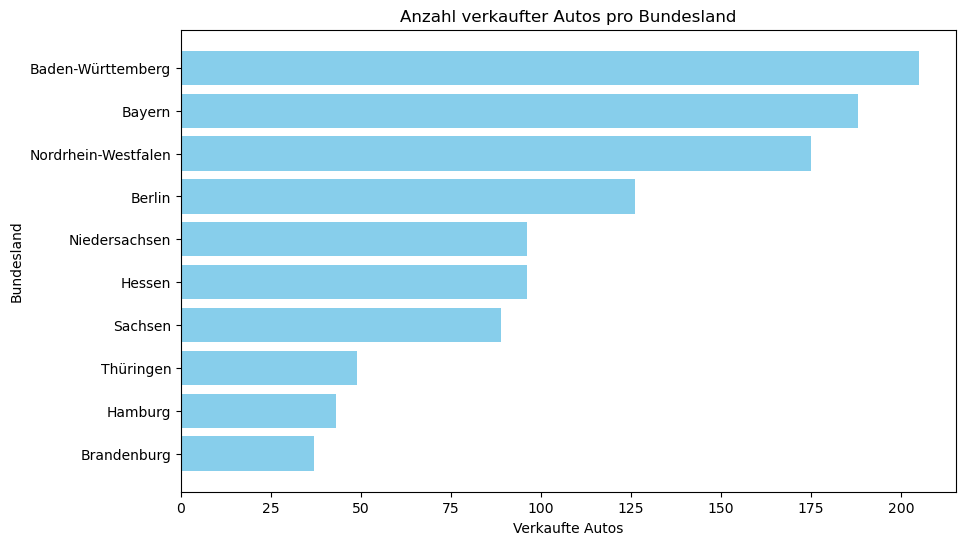

In [62]:
plt.figure(figsize=(10, 6))
plt.barh(verkäufe_pro_bundesland['Bundesland'], verkäufe_pro_bundesland['Verkaufte Autos'], color='skyblue')
plt.xlabel('Verkaufte Autos')
plt.ylabel('Bundesland')
plt.title('Anzahl verkaufter Autos pro Bundesland')
plt.show()

# F5. Wie hoch war der durchschnittliche Umsatz pro Bundesland?

```python
bundeslaender= combined[combined['Preis'].notna()]['Niederlassung'].unique()

umsatz_pro_bundesland = {}

for bundesland in bundeslaender:
    umsatz_pro_bundesland[bundesland] = combined[(combined['Niederlassung'] == bundesland) & (combined['Preis'].notna())]['Preis'].astype(float).mean()
    
umsatz_pro_bundesland_df = pd.DataFrame(umsatz_pro_bundesland.items(), columns=['Niederlassung','Durchschnittlicher Umsatz'])

umsatz_pro_bundesland_df['Durchschnittlicher Umsatz'] = umsatz_pro_bundesland_df['Durchschnittlicher Umsatz'].round(2)
umsatz_pro_bundesland_df = umsatz_pro_bundesland_df.sort_values(by='Durchschnittlicher Umsatz', ascending=False)


print(f"F5: Durchschnittlicher Umsatz pro Bundesland:\n{umsatz_pro_bundesland_df.to_string(index=False)}")
```

# Visualisierung

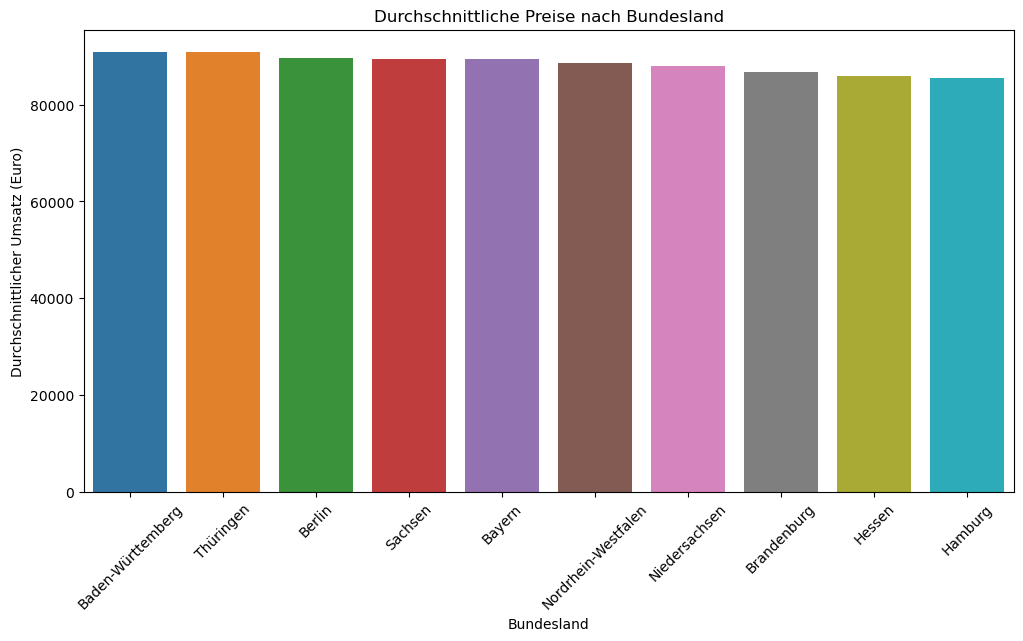

In [64]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Niederlassung', y='Durchschnittlicher Umsatz', data=umsatz_pro_bundesland_df)
plt.title('Durchschnittliche Preise nach Bundesland')
plt.xlabel('Bundesland')
plt.ylabel('Durchschnittlicher Umsatz (Euro)')
plt.xticks(rotation=45)
plt.show()

# Ausgabe

In [33]:
print(f"F5: Durchschnittlicher Umsatz pro Bundesland:\n{umsatz_pro_bundesland_df.to_string(index=False)}")

F5: Durchschnittlicher Umsatz pro Bundesland:
      Niederlassung  Durchschnittlicher Umsatz
  Baden-Württemberg                   90969.56
          Thüringen                   90816.99
             Berlin                   89584.98
            Sachsen                   89455.08
             Bayern                   89344.31
Nordrhein-Westfalen                   88633.27
      Niedersachsen                   87963.31
        Brandenburg                   86673.64
             Hessen                   85864.93
            Hamburg                   85549.50


# F6. In welchem Bundesland wurde das teuerste Auto verkauft?

 ```python
# Zuerst sicherstellen, dass die Preise als Float interpretiert werden koennen
combined['Preis'] = combined['Preis'].astype(float)

# Bundeslaender mit dem hoechsten durchschnittlichen Preis ermitteln
durchschnittlicher_preis_pro_bundesland = combined.groupby('Niederlassung')['Preis'].mean()
teuerstes_bundesland = durchschnittlicher_preis_pro_bundesland.idxmax()
hoechster_preis = durchschnittlicher_preis_pro_bundesland.max()

print(f"Das teuerste Auto wurde im Bundesland {teuerstes_bundesland} verkauft, mit einem Durchschnittspreis von {hoechster_preis:.2f}.")
```

# Ausgabe

Das teuerste Auto wurde im Bundesland Baden-Wuerttemberg verkauft, mit einem Durchschnittspreis von 90969.56 Euro!

# F7. Haben mehr Frauen oder mehr Männer unsere Autos gekauft?

```python
# combined = pd.read_csv('combined.csv')

# Filtern nach "Preis", sodass nur die verkauften Autos betrachtet werden
verkaufte_autos = combined.dropna(subset=['Preis'])

# Anzahl der verkauften Autos nach Geschlecht zählen
geschlechter = verkaufte_autos['Geschlecht'].value_counts()

# Berechnung der Ergebnisse
maenner = geschlechter.get(1, 0)
frauen = geschlechter.get(0, 0)

# Ausgabe der Ergbenisse
print(f"Insgesamt haben {maenner} Maenner unsere Autos gekauft.")
print(f"Insgesamt haben {frauen} Frauen unsere Autos gekauft.\n")

# Berechnung und Ausgabe des Ergebnisses, ob mehr maennliche oder mehr weibliche Kunden
if maenner > frauen:
    print("Wir haben mehr maennliche Kunden.")
elif frauen > maenner:
    print("Wir haben mehr weibliche Kunden.")
else:
    print("Unsere Kundschaft ist zu gleichen Teilen maennlich und weiblich.")
```

# Ausgabe

In [50]:

print(f"Insgesamt haben {maenner} Maenner unsere Autos gekauft.")
print(f"Insgesamt haben {frauen} Frauen unsere Autos gekauft.\n")
if maenner > frauen:
    print("Wir haben mehr männliche Kunden.")
elif frauen > maenner:
    print("Wir haben mehr weibliche Kunden.")
else:
    print("Unsere Kundschaft ist zu gleichen Teilen männlich und weiblich.")

Insgesamt haben 398 Maenner unsere Autos gekauft.
Insgesamt haben 701 Frauen unsere Autos gekauft.

Wir haben mehr weibliche Kunden.


# F8. Wie hoch ist das Durchschnittsalter unserer Kunden? Wie hoch ist das Durchschnittsalter unserer Besucher?

```python
#Funktion zur Entfernung von Ausreissern IQR:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column]>= lower_bound)&(df[column]<= upper_bound)]
#Aufteilung Kunden/Besucher
kunden = combined[combined['Preis'].notna()]
besucher = combined[combined['Preis'].isna()]

#Aureisser werden entfernt
kunden = remove_outliers(kunden, 'Alter')
besucher = remove_outliers(besucher, 'Alter')

#Durchschnittsalter der beiden Gruppen
avg_alter_kunden = kunden['Alter'].astype(float).mean()
avg_alter_besucher = besucher['Alter'].astype(float).mean()

#Print
print(f"F8: Durchschnittliches Alter der Kunden: {avg_alter_kunden: .2f}")
print(f"F8: Durchschnittliches Alter der Besucher: {avg_alter_besucher: .2f}")
```

# Ausgabe

In [55]:
print(f"F8: Durchschnittliches Alter der Kunden: {avg_alter_kunden : .2f}")
print(f"F8: Durchschnittliches Alter der Besucher: {avg_alter_besucher: .2f}")

F8: Durchschnittliches Alter der Kunden:  50.38
F8: Durchschnittliches Alter der Besucher:  49.88


# F9. Wie hoch ist das Durchschnittseinkommen unserer Kunden? Wie hoch ist das Durchschnittseinkommen unserer Besucher?

# F10. Bestimmen Sie, ob es einen statistisch signifikanten Unterschied zwischen dem Durchschnittseinkommen der Kunden und dem Durchschnittseinkommen der Besucher gibt.

``` python
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)   #AUF AUFREISSER AUFPASSEN!!!!
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Bereinigung der Daten
kunden_einkommen = combined[combined['Preis'].notna()]['Einkommen']
besucher_einkommen = combined[combined['Preis'].isna()]['Einkommen']

# Entfernen der Ausreisser
kunden_einkommen_cleaned = remove_outliers(combined[combined['Preis'].notna()], 'Einkommen')['Einkommen']
besucher_einkommen_cleaned = remove_outliers(combined[combined['Preis'].isna()], 'Einkommen')['Einkommen']

# Durchschnittseinkommen after Cleanup - Frage 9
avg_einkommen_kunden_cleaned = kunden_einkommen_cleaned.mean()
avg_einkommen_besucher_cleaned = besucher_einkommen_cleaned.mean()

print(f"Durchschnittseinkommen der Kunden : {avg_einkommen_kunden_cleaned:.2f} Euro")
print(f"Durchschnittseinkommen der Besucher : {avg_einkommen_besucher_cleaned:.2f} Euro")

```

```python
# Zweistichproben-t-Test mit bereinigten Daten
t_stat, p_val = ttest_ind(
    kunden_einkommen_cleaned,
    besucher_einkommen_cleaned,
    equal_var=True
)

# Signifikanzniveau
alpha = 0.05

# Überprüfung, ob der Unterschied statistisch signifikant ist
signifikanz = 'statistisch signifikant' if p_val < alpha else 'nicht statistisch signifikant'
print(f"Der Unterschied im Durchschnittseinkommen zwischen Kunden und Besuchern ist {signifikanz} (p-Wert: {p_val:.4f}).")
```

# Ausgabe

In [36]:
print(f"Durchschnittseinkommen der Kunden : {avg_einkommen_kunden_cleaned:.2f} Euro")
print(f"Durchschnittseinkommen der Besucher : {avg_einkommen_besucher_cleaned:.2f} Euro")
signifikanz = 'statistisch signifikant' if p_val < alpha else 'nicht statistisch signifikant'
print(f"Der Unterschied im Durchschnittseinkommen zwischen Kunden und Besuchern ist {signifikanz} (p-Wert: {p_val:.4f}).")

Durchschnittseinkommen der Kunden : 58850.55 Euro
Durchschnittseinkommen der Besucher : 59420.53 Euro
Der Unterschied im Durchschnittseinkommen zwischen Kunden und Besuchern ist nicht statistisch signifikant (p-Wert: 0.4365).


# F11. Wie hoch ist die Korrelation (Pearson-Korrelation) zwischen den Variablen Alter, Einkommen, Preis und Zeit?

```python
# Um die Korrelation zu berechnen, verwenden wir die corr()-Funktion von Pandas DataFrame
correlation_matrix = combined[['Alter', 'Einkommen', 'Preis', 'Zeit']].astype(float).corr(method='pearson')

# Ausgabe der Korrelationsmatrix
print("Pearson-Korrelation zwischen Alter, Einkommen, Preis und Zeit:")
print(correlation_matrix)
```

# Ausgabe

In [37]:
print("Pearson-Korrelation zwischen Alter, Einkommen, Preis und Zeit:")
print(correlation_matrix)

Pearson-Korrelation zwischen Alter, Einkommen, Preis und Zeit:
              Alter  Einkommen     Preis      Zeit
Alter      1.000000   0.769915  0.780478  0.315136
Einkommen  0.769915   1.000000  0.864833  0.388928
Preis      0.780478   0.864833  1.000000  0.707778
Zeit       0.315136   0.388928  0.707778  1.000000


# Visualisierung

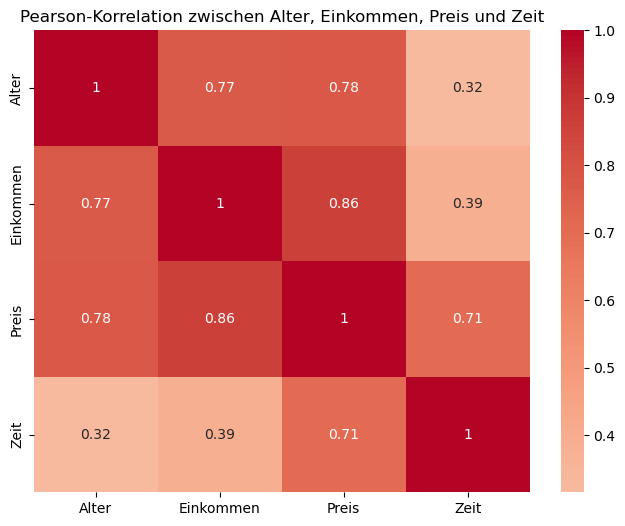

In [65]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson-Korrelation zwischen Alter, Einkommen, Preis und Zeit')
plt.show()

# F12. Testen Sie grafisch mit Hilfe eines qq-Plots, ob die Variable Zeit approximativ normalverteilt ist.

```python
# Umwandeln der Zeit-Spalte in float und Behandlung von NaN-Werten
combined['Zeit'] = pd.to_numeric(combined['Zeit'], errors='coerce')

# Entfernen von NaN-Werten, da sie den QQ-Plot beeinflussen koennen
zeit_clean = combined['Zeit'].dropna()

# Erstellen des QQ-Plots
stats.probplot(zeit_clean, dist="norm", plot=plt)
plt.title('QQ Plot - Zeit')
plt.xlabel('Theoretische Quantile')
plt.ylabel('Datenquantile')
plt.show()
```

# Ausgabe

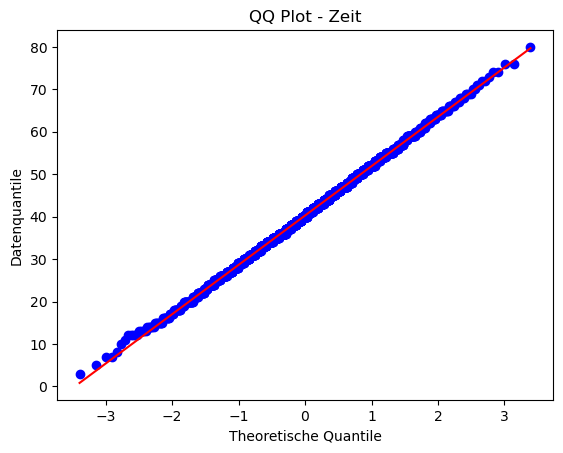

In [38]:
stats.probplot(zeit_clean, dist="norm", plot=plt)
plt.title('QQ Plot - Zeit')
plt.xlabel('Theoretische Quantile')
plt.ylabel('Datenquantile')
plt.show()

# F13. Wie viele Kunden haben keinen Bankkredit aufgenommen, um das Auto zu kaufen?

```python
# combined = pd.read_csv('combined.csv')

# Annahme: Kunden, deren Gehalt hoeher ist als der Kaufpreis nehmen keinen Kredit auf
kunden_mit_kredit = combined[combined['Einkommen'] < combined['Preis']]

# Kunden die einen Kredit aufgenommen haben zaehlen
kredite = len(kunden_mit_kredit)

# Ausgabe des Ergebnisses
print(f"Es haben insgesamt {kredite} Kunden einen Kredit fuer den Kauf aufgenommen.")
```

# Ausgabe

In [56]:
print(f"Es haben insgesamt {kredite} Kunden einen Kredit fuer den Kauf aufgenommen.")

Es haben insgesamt 1099 Kunden einen Kredit fuer den Kauf aufgenommen.


### F14. Welche sozioökonomischen Merkmale beeinflussen den Kaufpreis? Wählen Sie die geeigneten unabhängigen Variablen aus und schätzen Sie eine Regression unter Verwendung der geeigneten Methode.

```python
# Daten einlesen
combined = pd.read_csv('combined.csv')

# Sicherstellen, dass die relevanten Spalten vorhanden sind
print(combined.columns)

# Umwandeln von relevanten Spalten in numerische Werte
combined['Alter'] = pd.to_numeric(combined['Alter'], errors='coerce')
combined['Einkommen'] = pd.to_numeric(combined['Einkommen'], errors='coerce')
combined['Preis'] = pd.to_numeric(combined['Preis'], errors='coerce')
combined['Zeit'] = pd.to_numeric(combined['Zeit'], errors='coerce')

# Filtern der Daten um NaN-Werte zu entfernen (aber keine Ausreisser filtern)
combined = combined.dropna(subset=['Preis', 'Alter', 'Einkommen', 'Zeit'])

# Unabhaengige Variablen
X = combined[['Alter', 'Einkommen', 'Zeit']]

# Abhaengige Variable
y = combined['Preis']

# Hinzufuegen eines konstanten Terms zur Regressionsgleichung
X = sm.add_constant(X)

# Regression durchfuehren
model = sm.OLS(y, X).fit()

# Zusammenfassung des Modells ausgeben
print(model.summary())
```

# Ausgabe 

In [40]:
combined = pd.read_csv('combined.csv')
print(combined.columns)
combined['Alter'] = pd.to_numeric(combined['Alter'], errors='coerce')
combined['Einkommen'] = pd.to_numeric(combined['Einkommen'], errors='coerce')
combined['Preis'] = pd.to_numeric(combined['Preis'], errors='coerce')
combined['Zeit'] = pd.to_numeric(combined['Zeit'], errors='coerce')
combined = combined.dropna(subset=['Preis', 'Alter', 'Einkommen', 'Zeit'])
X = combined[['Alter', 'Einkommen', 'Zeit']]
y = combined['Preis']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

Index(['Alter', 'Einkommen', 'Preis', 'Geschlecht', 'Zeit', 'KundeNr',
       'Niederlassung'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                  Preis   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     1475.
Date:                Thu, 27 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:53:19   Log-Likelihood:                -11831.
No. Observations:                1104   AIC:                         2.367e+04
Df Residuals:                    1100   BIC:                         2.369e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------

### F15. Prognostizieren Sie den Kaufpreis eines unserer Autos für einen männlichen kunden im Alter von 32 Jahren mit einem Einkommen von 30.000 Euro. Prognostizieren Sie den Kaufpreis eines unserer Autos für einen männlichen Kunden im Alter von 51 Jahren und mit einem Einkommen von 54.000 Euro.

```python 
# Zusammenfuegen der DataFrames
besucher['Preis'] = np.nan
cols = list(besucher.columns)
cols.insert(2, cols.pop(cols.index('Preis')))
besucher = besucher[cols]
combined_draft = pd.concat([kunden, besucher], ignore_index=True, axis=0)

# Ersetzen von Kommas durch Punkte und Konvertieren der Spalten in numerische Werte
combined_draft['Einkommen'] = combined_draft['Einkommen'].astype(str).str.replace(',', '.').astype(float)
combined_draft['Preis'] = combined_draft['Preis'].astype(str).str.replace(',', '.').astype(float)
combined_draft['Alter'] = combined_draft['Alter'].astype(int)
combined_draft['Geschlecht'] = combined_draft['Geschlecht'].astype(float)

# Filtern der Daten fuer maennliche Kunden
males = combined_draft[combined_draft['Geschlecht'] == 1.0]

# Entfernen von Zeilen mit fehlenden Werten
males = males.dropna(subset=['Preis'])

```

```python
# Lineare Regression
X = males[['Alter', 'Einkommen']]
y = males['Preis']
# Modelltraining
model = LinearRegression()
model.fit(X, y)

# Prognose fuer die beiden gegebenen Faelle
kunden1 = np.array([[32, 30000]])
kunden2 = np.array([[51, 54000]])

preis1 = model.predict(kunden1)
preis2 = model.predict(kunden2)

print(f'Prognostizierter Kaufpreis fuer einen 32-jaehrigen Kunden mit einem Einkommen von 30.000 Euro: {preis1[0]:.2f} Euro')
print(f'Prognostizierter Kaufpreis fuer einen 51-jaehrigen Kunden mit einem Einkommen von 54.000 Euro: {preis2[0]:.2f} Euro')
```

# Ausgabe

In [57]:
print(f'Prognostizierter Kaufpreis fuer einen 32-jaehrigen Kunden mit einem Einkommen von 30.000 Euro: {preis1[0]:.2f} Euro')
print(f'Prognostizierter Kaufpreis fuer einen 51-jaehrigen Kunden mit einem Einkommen von 54.000 Euro: {preis2[0]:.2f} Euro')

Prognostizierter Kaufpreis fuer einen 32-jaehrigen Kunden mit einem Einkommen von 30.000 Euro: 51393.47 Euro
Prognostizierter Kaufpreis fuer einen 51-jaehrigen Kunden mit einem Einkommen von 54.000 Euro: 85540.93 Euro


# F16. Welche Variable beeinflusst den Preis des Autos am meisten?

```python 
# combined = pd.read_csv('combined.csv')

# Entfernen von Zeilen mit fehlenden Werten in den relevanten Spalten
combined = combined.dropna()

# Entfernen von negativen Werten in den Spalten "Einkommen" und "Preis"
combined = combined[(combined['Einkommen'] >= 0) & (combined['Preis'] >= 0)]

# Konvertieren von Kategorien in numerische Werte (falls notwendig)
if 'Geschlecht' in combined.columns:
    combined = pd.get_dummies(combined, columns=['Geschlecht'], drop_first=True)
else:
    print("Warnung: Die Spalte 'Geschlecht' ist nicht im DataFrame enthalten.")

# Auswahl der Merkmale und der Zielvariable
features = ['Alter', 'Einkommen'] + [col for col in combined.columns if 'Geschlecht' in col]
target = 'Preis'
X = combined[features]
y = combined[target]

# Standardisieren der Merkmale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


```

```python
# Durchfuehren der Regressionsanalyse
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
#print(f'Modell R^2 Score: {score}')

# Regressionskoeffizienten anzeigen
coefficients = model.coef_
coeff_df = pd.DataFrame(coefficients, index=features, columns=['Koeffizient'])
print(coeff_df.round(2))

# Interpretieren der Regressionskoeffizienten
max_coefficient = coeff_df.max().round(2)[0]
print()
print(f"Die Variable 'Einkommen' hat mit einem Wert von {max_coefficient} den hoechsten absoluten Koeffizientenwert und beeinflusst damit den Preis des Autos am meisten.")
```

# Ausgabe 

In [58]:



combined = combined.dropna()


combined = combined[(combined['Einkommen'] >= 0) & (combined['Preis'] >= 0)]


if 'Geschlecht' in combined.columns:
    combined = pd.get_dummies(combined, columns=['Geschlecht'], drop_first=True)
else:
    print("Warnung: Die Spalte 'Geschlecht' ist nicht im DataFrame enthalten.")


features = ['Alter', 'Einkommen'] + [col for col in combined.columns if 'Geschlecht' in col]
target = 'Preis'
X = combined[features]
y = combined[target]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)


coefficients = model.coef_
coeff_df = pd.DataFrame(coefficients, index=features, columns=['Koeffizient'])
print(coeff_df.round(2))


max_coefficient = coeff_df.max().round(2)[0]
print()
print(f"Die Variable 'Einkommen' hat mit einem Wert von {max_coefficient} den hoechsten absoluten Koeffizientenwert und beeinflusst damit den Preis des Autos am meisten.")

                Koeffizient
Alter               7095.29
Einkommen          16267.47
Geschlecht_1.0      1235.64

Die Variable 'Einkommen' hat mit einem Wert von 16267.47 den hoechsten absoluten Koeffizientenwert und beeinflusst damit den Preis des Autos am meisten.


# F17. Schätzen Sie eine Regression, die die Wahrscheinlichkeit des Kaufs eines Autos ermittelt.

```python
combined = pd.read_csv('combined.csv')

print(combined.columns)

# Umwandeln  in numerische Werte
combined['Alter'] = pd.to_numeric(combined['Alter'], errors='coerce')
combined['Einkommen'] = pd.to_numeric(combined['Einkommen'], errors='coerce')
combined['Preis'] = pd.to_numeric(combined['Preis'], errors='coerce')
combined['Zeit'] = pd.to_numeric(combined['Zeit'], errors='coerce')

#  binaere Zielvariable 'Gekauft'
combined['Gekauft'] = np.where(combined['Preis'].notna(), 1, 0)

# Filtern der Daten (NaN entfernen)
combined = combined.dropna(subset=['Alter', 'Einkommen', 'Zeit'])

# Unabhaengige Variablen
X = combined[['Alter', 'Einkommen', 'Zeit']]

# Abhaengige Variable
y = combined['Gekauft']

# Intercept
X = sm.add_constant(X)

# Logistische Regression
logit_model = sm.Logit(y, X).fit()

# Print des Modells
print(logit_model.summary())

# Wahrscheinlichkeitenberechnen
combined['Kaufwahrscheinlichkeit'] = logit_model.predict(X)

# Anzeige der Wahrscheinlichkeiten fuer die ersten Zeilen
print(combined[['Alter', 'Einkommen', 'Zeit', 'Kaufwahrscheinlichkeit']].head())
```

```python
# Unabhaengige Variablen
X = combined[['Alter', 'Einkommen', 'Zeit']]

# Abhaengige Variable
y = combined['Gekauft']

# Intercept
X = sm.add_constant(X)

# Logistische Regression
logit_model = sm.Logit(y, X).fit()

# Print des Modells
print(logit_model.summary())

# Wahrscheinlichkeitenberechnen
combined['Kaufwahrscheinlichkeit'] = logit_model.predict(X)

# Anzeige der Wahrscheinlichkeiten fuer die ersten Zeilen
print(combined[['Alter', 'Einkommen', 'Zeit', 'Kaufwahrscheinlichkeit']].head())
```

# Ausgabe

In [43]:
combined = pd.read_csv('combined.csv')

print(combined.columns)


combined['Alter'] = pd.to_numeric(combined['Alter'], errors='coerce')
combined['Einkommen'] = pd.to_numeric(combined['Einkommen'], errors='coerce')
combined['Preis'] = pd.to_numeric(combined['Preis'], errors='coerce')
combined['Zeit'] = pd.to_numeric(combined['Zeit'], errors='coerce')


combined['Gekauft'] = np.where(combined['Preis'].notna(), 1, 0)


combined = combined.dropna(subset=['Alter', 'Einkommen', 'Zeit'])


X = combined[['Alter', 'Einkommen', 'Zeit']]


y = combined['Gekauft']


X = sm.add_constant(X)


logit_model = sm.Logit(y, X).fit()


print(logit_model.summary())


combined['Kaufwahrscheinlichkeit'] = logit_model.predict(X)


print(combined[['Alter', 'Einkommen', 'Zeit', 'Kaufwahrscheinlichkeit']].head())

Index(['Alter', 'Einkommen', 'Preis', 'Geschlecht', 'Zeit', 'KundeNr',
       'Niederlassung'],
      dtype='object')
Optimization terminated successfully.
         Current function value: 0.580267
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Gekauft   No. Observations:                 1995
Model:                          Logit   Df Residuals:                     1991
Method:                           MLE   Df Model:                            3
Date:                Thu, 27 Jun 2024   Pseudo R-squ.:                  0.1559
Time:                        06:53:19   Log-Likelihood:                -1157.6
converged:                       True   LL-Null:                       -1371.4
Covariance Type:            nonrobust   LLR p-value:                 2.316e-92
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

# Visualisierung der Kaufwahrscheinlichkeit

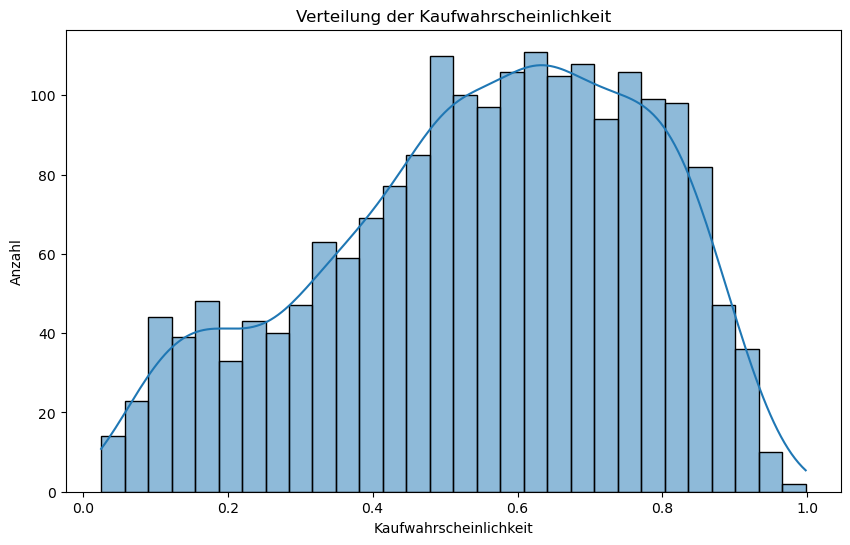

In [44]:
plt.figure(figsize=(10, 6))
sns.histplot(combined['Kaufwahrscheinlichkeit'], bins=30, kde=True)
plt.title('Verteilung der Kaufwahrscheinlichkeit')
plt.xlabel('Kaufwahrscheinlichkeit')
plt.ylabel('Anzahl')
plt.show()

### F18. Wie hoch ist die Wahrscheinlichkeit, dass ein 32-Jähriger männlicher Kunde mit einem Einkommen von 30.000 Euro, der das Auto 30 Minuten lang getestet hat, eines unserer Modelle kauft? Wie hoch ist die Wahrscheinlichkeit, dass ein 51-Jähriger männlicher Kunde mit einem Einkommen von 54.000 euro, der das Auto 45 Minuten lang getestet hat, eines unserer Modelle kauft?


```python
combined = pd.read_csv('combined.csv')

print("Spaltenübersicht:", combined.columns)

# numerische Werte
combined['Alter'] = pd.to_numeric(combined['Alter'], errors='coerce')
combined['Einkommen'] = pd.to_numeric(combined['Einkommen'], errors='coerce')
combined['Preis'] = pd.to_numeric(combined['Preis'], errors='coerce')
combined['Zeit'] = pd.to_numeric(combined['Zeit'], errors='coerce')

# Binäre Zielvariable 'Gekauft' erstellen, wobei 1 = gekauft, 0 = nicht gekauft
combined['Gekauft'] = np.where(combined['Preis'].notna(), 1, 0)

# Entfernen von Zeilen mit fehlenden Werten in den relevanten Spalten
combined = combined.dropna(subset=['Alter', 'Einkommen', 'Zeit'])

# Unabhaengige Variablen 
X = combined[['Alter', 'Einkommen', 'Zeit']]

# Abhaengige Variable
y = combined['Gekauft']

# Intercept zur Regressionsgleichung
X = sm.add_constant(X)


```

```python
# logistische Regression
logit_model = sm.Logit(y, X).fit()

# Zusammenfassung des Modells ausgeben
print(logit_model.summary())

# Spezifikationen aus der Aufgabenstellung
# Kunde 1: 32 Jahre alt, 30.000 Euro Einkommen, 30 Minuten Testzeit
kunde_1 = {'const': 1, 'Alter': 32, 'Einkommen': 30000, 'Zeit': 30}

# Kunde 2: 51 Jahre alt, 54.000 Euro Einkommen, 45 Minuten Testzeit
kunde_2 = {'const': 1, 'Alter': 51, 'Einkommen': 54000, 'Zeit': 45}

# Umwandeln in DataFrames 
kunde_1_df = pd.DataFrame([kunde_1])
kunde_2_df = pd.DataFrame([kunde_2])

# Berechnung der Logit-Werte, sog. logodds, für die beiden Kunden
logit_kunde_1 = logit_model.predict(kunde_1_df)
logit_kunde_2 = logit_model.predict(kunde_2_df)

# Umwandlung der Werte in Prozent
wahrscheinlichkeit_kunde_1 = (1 / (1 + np.exp(-logit_kunde_1))) * 100
wahrscheinlichkeit_kunde_2 = (1 / (1 + np.exp(-logit_kunde_2))) * 100

# Ausgabe der Wahrscheinlichkeiten in Prozent
print(f"Die Wahrscheinlichkeit, dass ein 32-jaehriger Kunde mit einem Einkommen von 30.000 Euro und 30 Minuten Testzeit ein Auto kauft, betraegt {wahrscheinlichkeit_kunde_1.iloc[0]:.2f}%.")
print(f"Die Wahrscheinlichkeit, dass ein 51-jaehriger Kunde mit einem Einkommen von 54.000 Euro und 45 Minuten Testzeit ein Auto kauft, betraegt {wahrscheinlichkeit_kunde_2.iloc[0]:.2f}%.")
```

# Ausgabe

In [59]:
print(f"Die Wahrscheinlichkeit, dass ein 32-jaehriger Kunde mit einem Einkommen von 30.000 Euro und 30 Minuten Testzeit ein Auto kauft, betraegt {wahrscheinlichkeit_kunde_1.iloc[0]:.2f}%.")
print(f"Die Wahrscheinlichkeit, dass ein 51-jaehriger Kunde mit einem Einkommen von 54.000 Euro und 45 Minuten Testzeit ein Auto kauft, betraegt {wahrscheinlichkeit_kunde_2.iloc[0]:.2f}%.")

Die Wahrscheinlichkeit, dass ein 32-jaehriger Kunde mit einem Einkommen von 30.000 Euro und 30 Minuten Testzeit ein Auto kauft, betraegt 62.75%.
Die Wahrscheinlichkeit, dass ein 51-jaehriger Kunde mit einem Einkommen von 54.000 Euro und 45 Minuten Testzeit ein Auto kauft, betraegt 67.28%.


# F19. Auf welche Probleme sind Sie bei der Zusammenführung des Datensatzes gestoßen?

In [61]:
print("Folgende Probleme sind aufgetreten:\n\n"
     
    "1. Einfuegen einer fehlenden Spalte: besucher['Preis'] = ''\n\n"
    "2. Einfuegen der Spalte und Setzen an richtige Stelle: cols.insert()\n\n"
    "3. Ersetzen der falsch bezeichneten Bundeslaender: land['Niederlassung'].replace()\n\n"
    "4. Zusammenfuehren der .csv und -txt Dateien: combined = pd.merge(combined_draft, land, on='KundeNr', how='right')\n\n"
    "5. Ersetzen von ',' in '.': combined['Zeit'].astype(str).str.replace(',', '.', regex=False)\n\n"
    "6. Umwandeln der Werte in numerische Werte: combined[col] = pd.to_numeric()\n\n"
    "7. Ersetzen der Ausreisser durch den Medianwert: combined[col] = np.where(np.abs(z_scores[col]) > 3, median, combined[col])")

Folgende Probleme sind aufgetreten:

1. Einfuegen einer fehlenden Spalte: besucher['Preis'] = ''

2. Einfuegen der Spalte und Setzen an richtige Stelle: cols.insert()

3. Ersetzen der falsch bezeichneten Bundeslaender: land['Niederlassung'].replace()

4. Zusammenfuehren der .csv und -txt Dateien: combined = pd.merge(combined_draft, land, on='KundeNr', how='right')

5. Ersetzen von ',' in '.': combined['Zeit'].astype(str).str.replace(',', '.', regex=False)

6. Umwandeln der Werte in numerische Werte: combined[col] = pd.to_numeric()

7. Ersetzen der Ausreisser durch den Medianwert: combined[col] = np.where(np.abs(z_scores[col]) > 3, median, combined[col])


# Danke fuer Ihre Aufmerksamkeit!